##1. Tải bộ dữ liệu:

In [1]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
!unzip -q 'FER-2013.zip'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=a342c537-e23e-4aa8-83e5-87c533abd3d7
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:02<00:00, 25.0MB/s]


##2. Import các thư viện cần thiết:

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

##3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán:

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

##4. Đọc số lượng class trong dataset:

In [4]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)
label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

##5. Xây dựng DataLoader:

In [5]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = 128, 128

print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


In [6]:
class ImageDataset(Dataset):
    def __init__(self, im_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.im_dir = im_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.im_paths, self.im_labels = self.read_im_files()

        if split in ['train', 'val'] and 'train' in im_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.im_paths, self.im_labels)),
                train_size=train_ratio,
                random_state=random_seed,
                stratify=self.im_labels
            )

            if split == 'train':
                self.im_paths, self.im_labels = zip(*train_data)
            elif split == 'val':
                self.im_paths, self.im_labels = zip(*val_data)

    def read_im_files(self):
        im_paths, im_labels = [], []
        for cls in self.label2idx.keys():
            for im in os.listdir(os.path.join(self.im_dir, cls)):
                im_paths.append(os.path.join(self.im_dir, cls, im))
                im_labels.append(cls)

        return im_paths, im_labels

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = read_image(im_path)
        im = self.resize(im)
        im = im.type(torch.float32)
        label = self.label2idx[self.im_labels[idx]]
        if self.norm:
            im = (im / 127.5) - 1
        return im, label

In [7]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, 'train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, 'val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, 'test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

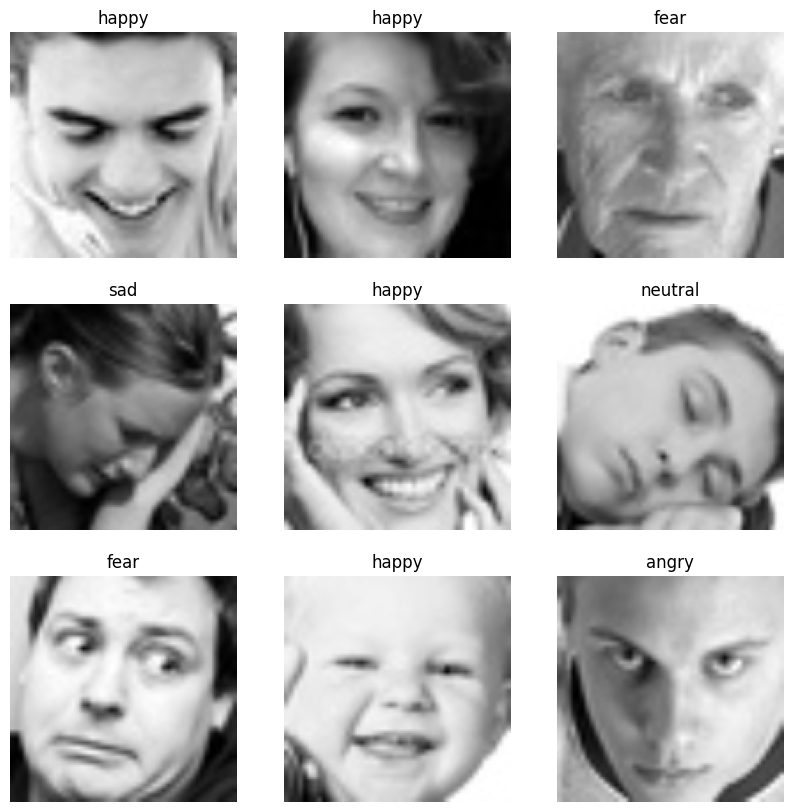

In [8]:
im_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = im_batch[i].numpy().min()
    maxv = im_batch[i].numpy().max()
    plt.imshow(np.squeeze(im_batch[i].numpy()), vmin=minv, vmax=maxv, cmap='gray')
    plt.title(idx2label[label_batch[i].item()])
    plt.axis('off')
plt.show()

##6. Xây dựng mạng MLP:

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.linear3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dim = img_height * img_width
output_dim = len(classes)
hidden_dim = 64

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

##7. Khai báo hàm loss và optimizer:

In [10]:
lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

##8. Xây dựng hàm tính độ chính xác:

In [11]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

##9. Huấn luyện mô hình:

In [12]:
epochs = 40
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(y_pred.detach().cpu())
        train_target.append(y_batch.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_predict, train_target))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.append(y_pred.cpu())
            val_target.append(y_batch.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_predict, val_target))

    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

Epoch 1/40:	train_loss: 1.916	val_loss: 1.890
Epoch 2/40:	train_loss: 1.863	val_loss: 1.838
Epoch 3/40:	train_loss: 1.819	val_loss: 1.806
Epoch 4/40:	train_loss: 1.793	val_loss: 1.785
Epoch 5/40:	train_loss: 1.775	val_loss: 1.768
Epoch 6/40:	train_loss: 1.757	val_loss: 1.751
Epoch 7/40:	train_loss: 1.738	val_loss: 1.731
Epoch 8/40:	train_loss: 1.716	val_loss: 1.707
Epoch 9/40:	train_loss: 1.695	val_loss: 1.688
Epoch 10/40:	train_loss: 1.676	val_loss: 1.672
Epoch 11/40:	train_loss: 1.662	val_loss: 1.659
Epoch 12/40:	train_loss: 1.648	val_loss: 1.649
Epoch 13/40:	train_loss: 1.637	val_loss: 1.641
Epoch 14/40:	train_loss: 1.628	val_loss: 1.633
Epoch 15/40:	train_loss: 1.618	val_loss: 1.625
Epoch 16/40:	train_loss: 1.610	val_loss: 1.617
Epoch 17/40:	train_loss: 1.602	val_loss: 1.610
Epoch 18/40:	train_loss: 1.593	val_loss: 1.607
Epoch 19/40:	train_loss: 1.585	val_loss: 1.600
Epoch 20/40:	train_loss: 1.578	val_loss: 1.595
Epoch 21/40:	train_loss: 1.570	val_loss: 1.589
Epoch 22/40:	train_los

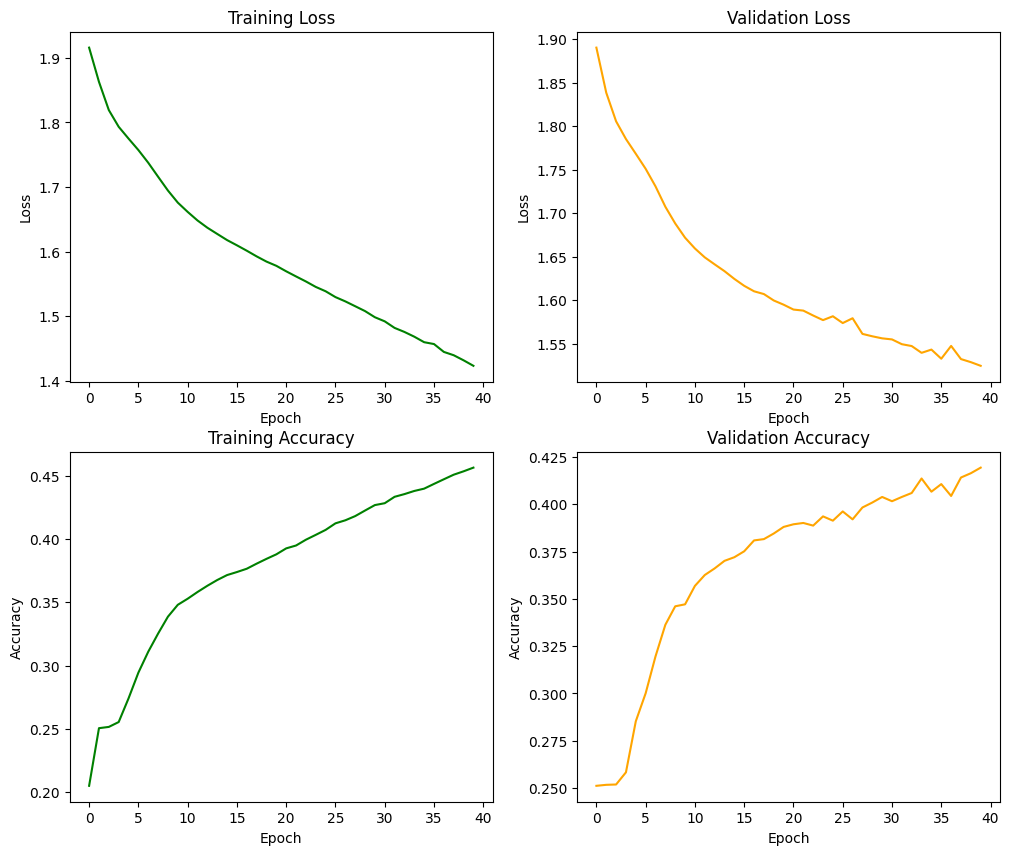

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

##10. Đánh giá mô hình:

In [14]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.4158539983282251


Image height: 128
Image width: 128


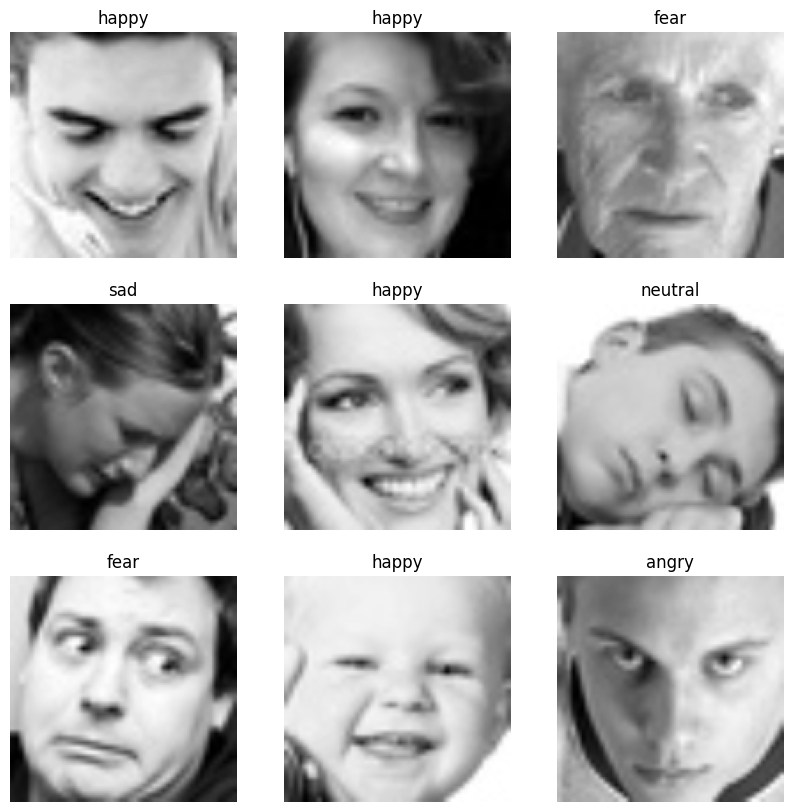

Epoch 1/40:	train_loss: nan	val_loss: nan
Epoch 2/40:	train_loss: nan	val_loss: nan
Epoch 3/40:	train_loss: nan	val_loss: nan
Epoch 4/40:	train_loss: nan	val_loss: nan
Epoch 5/40:	train_loss: nan	val_loss: nan
Epoch 6/40:	train_loss: nan	val_loss: nan
Epoch 7/40:	train_loss: nan	val_loss: nan
Epoch 8/40:	train_loss: nan	val_loss: nan
Epoch 9/40:	train_loss: nan	val_loss: nan
Epoch 10/40:	train_loss: nan	val_loss: nan
Epoch 11/40:	train_loss: nan	val_loss: nan
Epoch 12/40:	train_loss: nan	val_loss: nan
Epoch 13/40:	train_loss: nan	val_loss: nan
Epoch 14/40:	train_loss: nan	val_loss: nan
Epoch 15/40:	train_loss: nan	val_loss: nan
Epoch 16/40:	train_loss: nan	val_loss: nan
Epoch 17/40:	train_loss: nan	val_loss: nan
Epoch 18/40:	train_loss: nan	val_loss: nan
Epoch 19/40:	train_loss: nan	val_loss: nan
Epoch 20/40:	train_loss: nan	val_loss: nan
Epoch 21/40:	train_loss: nan	val_loss: nan
Epoch 22/40:	train_loss: nan	val_loss: nan
Epoch 23/40:	train_loss: nan	val_loss: nan
Epoch 24/40:	train_l

In [15]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)
label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = 128, 128

print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

class ImageDataset(Dataset):
    def __init__(self, im_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.im_dir = im_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.im_paths, self.im_labels = self.read_im_files()

        if split in ['train', 'val'] and 'train' in im_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.im_paths, self.im_labels)),
                train_size=train_ratio,
                random_state=random_seed,
                stratify=self.im_labels
            )

            if split == 'train':
                self.im_paths, self.im_labels = zip(*train_data)
            elif split == 'val':
                self.im_paths, self.im_labels = zip(*val_data)

    def read_im_files(self):
        im_paths, im_labels = [], []
        for cls in self.label2idx.keys():
            for im in os.listdir(os.path.join(self.im_dir, cls)):
                im_paths.append(os.path.join(self.im_dir, cls, im))
                im_labels.append(cls)

        return im_paths, im_labels

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = read_image(im_path)
        im = self.resize(im)
        im = im.type(torch.float32)
        label = self.label2idx[self.im_labels[idx]]

        # Bỏ phép normalization (xóa đoạn mã này)
        # if self.norm:
        #     im = (im / 127.5) - 1

        return im, label

batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, 'train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, 'val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, 'test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

im_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = im_batch[i].numpy().min()
    maxv = im_batch[i].numpy().max()
    plt.imshow(np.squeeze(im_batch[i].numpy()), vmin=minv, vmax=maxv, cmap='gray')
    plt.title(idx2label[label_batch[i].item()])
    plt.axis('off')
plt.show()

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.linear3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dim = img_height * img_width
output_dim = len(classes)
hidden_dim = 64

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

epochs = 40
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(y_pred.detach().cpu())
        train_target.append(y_batch.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_predict, train_target))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.append(y_pred.cpu())
            val_target.append(y_batch.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_predict, val_target))

    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Image height: 128
Image width: 128


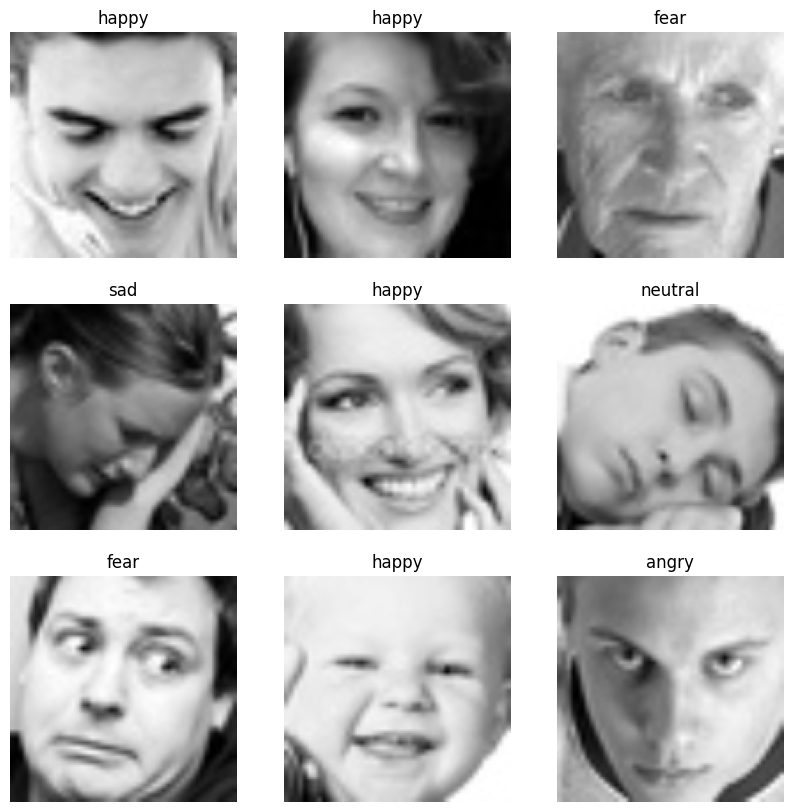

Epoch 1/40:	train_loss: 1.852	val_loss: 1.789
Epoch 2/40:	train_loss: 1.763	val_loss: 1.742
Epoch 3/40:	train_loss: 1.721	val_loss: 1.705
Epoch 4/40:	train_loss: 1.685	val_loss: 1.674
Epoch 5/40:	train_loss: 1.657	val_loss: 1.651
Epoch 6/40:	train_loss: 1.636	val_loss: 1.635
Epoch 7/40:	train_loss: 1.620	val_loss: 1.624
Epoch 8/40:	train_loss: 1.607	val_loss: 1.612
Epoch 9/40:	train_loss: 1.594	val_loss: 1.608
Epoch 10/40:	train_loss: 1.583	val_loss: 1.600
Epoch 11/40:	train_loss: 1.573	val_loss: 1.592
Epoch 12/40:	train_loss: 1.562	val_loss: 1.589
Epoch 13/40:	train_loss: 1.552	val_loss: 1.582
Epoch 14/40:	train_loss: 1.543	val_loss: 1.577
Epoch 15/40:	train_loss: 1.534	val_loss: 1.572
Epoch 16/40:	train_loss: 1.524	val_loss: 1.568
Epoch 17/40:	train_loss: 1.516	val_loss: 1.559
Epoch 18/40:	train_loss: 1.506	val_loss: 1.559
Epoch 19/40:	train_loss: 1.498	val_loss: 1.557
Epoch 20/40:	train_loss: 1.489	val_loss: 1.551
Epoch 21/40:	train_loss: 1.480	val_loss: 1.547
Epoch 22/40:	train_los

In [16]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)
label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = 128, 128

print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

class ImageDataset(Dataset):
    def __init__(self, im_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.im_dir = im_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.im_paths, self.im_labels = self.read_im_files()

        if split in ['train', 'val'] and 'train' in im_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.im_paths, self.im_labels)),
                train_size=train_ratio,
                random_state=random_seed,
                stratify=self.im_labels
            )

            if split == 'train':
                self.im_paths, self.im_labels = zip(*train_data)
            elif split == 'val':
                self.im_paths, self.im_labels = zip(*val_data)

    def read_im_files(self):
        im_paths, im_labels = [], []
        for cls in self.label2idx.keys():
            for im in os.listdir(os.path.join(self.im_dir, cls)):
                im_paths.append(os.path.join(self.im_dir, cls, im))
                im_labels.append(cls)

        return im_paths, im_labels

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = read_image(im_path)
        im = self.resize(im)
        im = im.type(torch.float32)
        label = self.label2idx[self.im_labels[idx]]
        if self.norm:
            im = (im / 127.5) - 1
        return im, label

batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, 'train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, 'val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, 'test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

im_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = im_batch[i].numpy().min()
    maxv = im_batch[i].numpy().max()
    plt.imshow(np.squeeze(im_batch[i].numpy()), vmin=minv, vmax=maxv, cmap='gray')
    plt.title(idx2label[label_batch[i].item()])
    plt.axis('off')
plt.show()

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        # Xóa dòng dưới đây để bỏ hidden layer thứ 3
        # self.linear3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output = nn.Linear(hidden_dim * 2, output_dim)  # Cập nhật lại output layer

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        # Bỏ dòng dưới đây
        # x = self.linear3(x)
        # x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dim = img_height * img_width
output_dim = len(classes)
hidden_dim = 64

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

epochs = 40
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(y_pred.detach().cpu())
        train_target.append(y_batch.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_predict, train_target))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.append(y_pred.cpu())
            val_target.append(y_batch.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_predict, val_target))

    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Image height: 128
Image width: 128


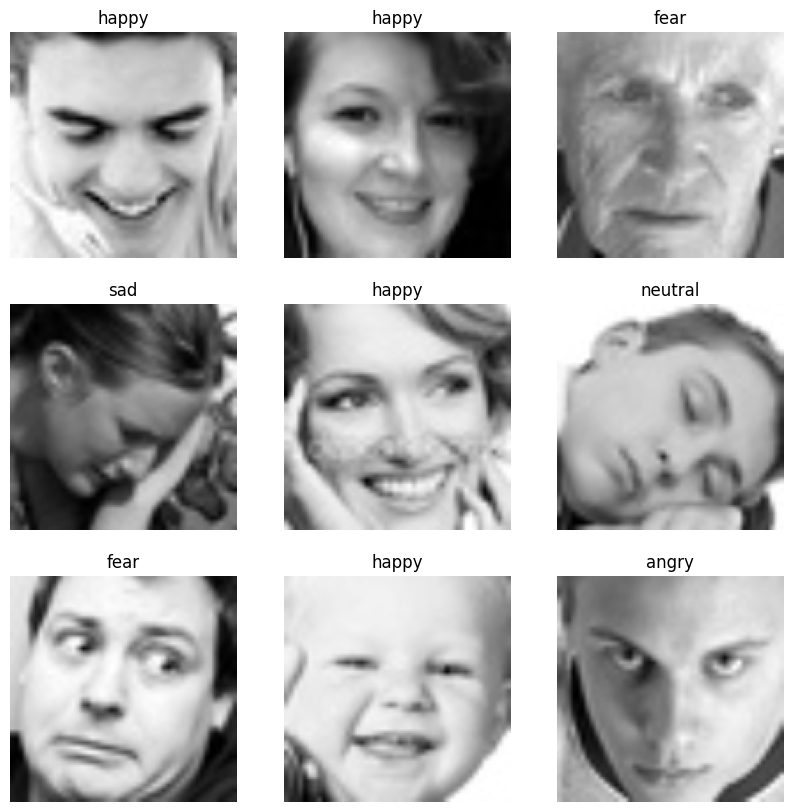

Epoch 1/40:	train_loss: 1.916	val_loss: 1.881
Epoch 2/40:	train_loss: 1.847	val_loss: 1.818
Epoch 3/40:	train_loss: 1.802	val_loss: 1.790
Epoch 4/40:	train_loss: 1.780	val_loss: 1.772
Epoch 5/40:	train_loss: 1.762	val_loss: 1.754
Epoch 6/40:	train_loss: 1.742	val_loss: 1.733
Epoch 7/40:	train_loss: 1.720	val_loss: 1.711
Epoch 8/40:	train_loss: 1.698	val_loss: 1.689
Epoch 9/40:	train_loss: 1.679	val_loss: 1.672
Epoch 10/40:	train_loss: 1.663	val_loss: 1.659
Epoch 11/40:	train_loss: 1.650	val_loss: 1.649
Epoch 12/40:	train_loss: 1.640	val_loss: 1.639
Epoch 13/40:	train_loss: 1.630	val_loss: 1.635
Epoch 14/40:	train_loss: 1.622	val_loss: 1.625
Epoch 15/40:	train_loss: 1.613	val_loss: 1.620
Epoch 16/40:	train_loss: 1.606	val_loss: 1.614
Epoch 17/40:	train_loss: 1.599	val_loss: 1.609
Epoch 18/40:	train_loss: 1.592	val_loss: 1.604
Epoch 19/40:	train_loss: 1.585	val_loss: 1.608
Epoch 20/40:	train_loss: 1.579	val_loss: 1.597
Epoch 21/40:	train_loss: 1.571	val_loss: 1.591
Epoch 22/40:	train_los

In [17]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)
label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = 128, 128

print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

class ImageDataset(Dataset):
    def __init__(self, im_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.im_dir = im_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.im_paths, self.im_labels = self.read_im_files()

        if split in ['train', 'val'] and 'train' in im_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.im_paths, self.im_labels)),
                train_size=train_ratio,
                random_state=random_seed,
                stratify=self.im_labels
            )

            if split == 'train':
                self.im_paths, self.im_labels = zip(*train_data)
            elif split == 'val':
                self.im_paths, self.im_labels = zip(*val_data)

    def read_im_files(self):
        im_paths, im_labels = [], []
        for cls in self.label2idx.keys():
            for im in os.listdir(os.path.join(self.im_dir, cls)):
                im_paths.append(os.path.join(self.im_dir, cls, im))
                im_labels.append(cls)

        return im_paths, im_labels

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = read_image(im_path)
        im = self.resize(im)
        im = im.type(torch.float32)
        label = self.label2idx[self.im_labels[idx]]
        if self.norm:
            im = (im / 127.5) - 1
        return im, label

batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, 'train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, 'val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, 'test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

im_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = im_batch[i].numpy().min()
    maxv = im_batch[i].numpy().max()
    plt.imshow(np.squeeze(im_batch[i].numpy()), vmin=minv, vmax=maxv, cmap='gray')
    plt.title(idx2label[label_batch[i].item()])
    plt.axis('off')
plt.show()

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dim = img_height * img_width
output_dim = len(classes)
hidden_dim = 64

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

epochs = 40
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(y_pred.detach().cpu())
        train_target.append(y_batch.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_predict, train_target))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.append(y_pred.cpu())
            val_target.append(y_batch.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_predict, val_target))

    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')